Importing libraries


In [5]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
import datetime
import matplotlib.pyplot as plt
from collections import Counter
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

Preproceesing data


In [6]:
def startsWithDateAndTimeAndroid(s):
    pattern='^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result=re.match(pattern, s)
    if result:
        return True
    return False 

In [7]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

In [8]:
def getDataPointAndroid(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(':') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

In [9]:
def getDataPointios(line):
    splitLine = line.split('] ')
    dateTime = splitLine[0]
    if ',' in dateTime:
        date, time = dateTime.split(',')
    else:
        date, time = dateTime.split(' ')
    message = ' '.join(splitLine[1:])
    if FindAuthor(message):
        splitMessage = message.split(':')
        author = splitMessage[0]
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    if time[5]==":":
        time = time[:5]+time[-3:]
    else:
        if 'AM' in time or 'PM' in time:
            time = time[:6]+time[-3:]
        else:
            time = time[:6]
    return date, time, author, message

In [10]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.EMOJI_DATA for char in word):
            emoji_list.append(word)

    return emoji_list

In [11]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = 'C:/Users/Ddmn/Desktop/project/chat.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    device=''
    first=fp.readline()
    print(first)
    if '[' in first:
      device='ios'
    else:
      device="android"
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None #message contains 4 things-"date","time","author","message" 
    while True:
        line = fp.readline() 
        if not line: 
            break
        if device=="ios":
          line = line.strip()
          if startsWithDateAndTimeios(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointios(line)
            messageBuffer.append(message)
          else:
            line= (line.encode('ascii', 'ignore')).decode("utf-8")
            if startsWithDateAndTimeios(line):
              if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
              messageBuffer.clear()
              date, time, author, message = getDataPointios(line)
              messageBuffer.append(message)
            else:
              messageBuffer.append(line)
        else:
          line = line.strip()
          if startsWithDateAndTimeAndroid(line): 
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointAndroid(line)
            messageBuffer.append(message)
          else:
            messageBuffer.append(line)

05/09/21, 9:56 pm - Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.



In [12]:
if device =='android':
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.dropna()
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
else:
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
        df = df.dropna()
        df["Date"] = df["Date"].apply(dateconv)
        df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

C:\Users\Ddmn\AppData\Local\Temp\ipykernel_6088\3096078804.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


In [13]:
df.head(2)

,Date,Time,Author,Message,emoji,urlcount
2,2021-05-09,9:57 pm,+91 97607 59222,👋,[👋],0
3,2021-05-09,9:57 pm,+91 97607 59222,Kal kon kon aara hai ?,[],0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32131 entries, 2 to 32631
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      32131 non-null  datetime64[ns]
 1   Time      32131 non-null  object        
 2   Author    32131 non-null  object        
 3   Message   32131 non-null  object        
 4   emoji     32131 non-null  object        
 5   urlcount  32131 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.7+ MB


In [15]:
df['month']=df['Date'].dt.month_name()
df['year']=df['Date'].dt.year
df['hour']=df['Date'].dt.hour
df['minute']=df['Date'].dt.minute

Finding Total no of group data


In [16]:
df.Author.unique()

array(['+91 97607 59222', '+91 90275 76619', 'Pradipt Kumar',
       'Harsh Verma ⭐', 'Harsh', 'Sidharth', '+91 6397 835 388',
       '+91 78954 21126', '+91 99978 37987', '+91 90843 12850',
       '+91 80776 02138', '+91 76186 10967', '+91 78959 12103',
       '+91 79836 85249', '+91 91197 47693', '+91 6397 690 526', 'Vikas',
       '+91 90847 55577', '+91 80060 11029', 'Kshitij', 'Ritik',
       '+91 78089 72535', 'Sarthak Badola', '+91 72519 45382',
       'Vipulchauhan', '+91 75359 79537', '+91 93680 85578',
       '+91 79066 52632', '+91 82186 47743', '+91 95575 91166',
       '+91 74650 85722', '+91 87916 65603', '+91 75004 58943',
       '+91 84459 76531', 'Arjun', '+91 95577 78057', '+91 90270 99943',
       '+91 82739 72984', '+91 82795 24659', '+91 74658 60027',
       '+91 90582 84113', '+91 94580 40950', '+91 84779 85507',
       'Sumit Chauhan', '+91 87555 27644', '+91 6206 272 365',
       '+91 6395 990 698', '+91 89792 70404', 'Mohit Anthwal',
       '+91 87911 44624', '

In [17]:
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32131 entries, 2 to 32631
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      32131 non-null  datetime64[ns]
 1   Time      32131 non-null  object        
 2   Author    32131 non-null  object        
 3   Message   32131 non-null  object        
 4   emoji     32131 non-null  object        
 5   urlcount  32131 non-null  int64         
 6   month     32131 non-null  object        
 7   year      32131 non-null  int32         
 8   hour      32131 non-null  int32         
 9   minute    32131 non-null  int32         
dtypes: datetime64[ns](1), int32(3), int64(1), object(5)
memory usage: 2.3+ MB


In [18]:
total_messages=df.shape[0]
print(total_messages)

32131


In [19]:
media_messages=df[df['Message']== '<Media omitted>'].shape[0]
print(media_messages)

0


In [20]:
emojis=sum(df['emoji'].str.len())
print(emojis)

7326


In [21]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len() 
links = np.sum(df.urlcount) 
print(links)

56


Separating media and text messages

In [22]:
link_messages=df[df['urlcount']>0]
deleted_messages=df[(df["Message"]=="You deleted this messages")| (df["Message"]=="This message was deleted.")]
media_messages_df = df[(df['Message'] == ' <Media omitted>')|(df['Message'] == ' image omitted')|(df['Message'] == ' video omitted')|(df['Message'] == ' sticker omitted')]
messages_df=df.drop(media_messages_df.index)
messages_df=messages_df.drop(deleted_messages.index)
messages_df=messages_df.drop(link_messages.index)

In [23]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27224 entries, 2 to 32631
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      27224 non-null  datetime64[ns]
 1   Time      27224 non-null  object        
 2   Author    27224 non-null  object        
 3   Message   27224 non-null  object        
 4   emoji     27224 non-null  object        
 5   urlcount  27224 non-null  int64         
 6   month     27224 non-null  object        
 7   year      27224 non-null  int32         
 8   hour      27224 non-null  int32         
 9   minute    27224 non-null  int32         
dtypes: datetime64[ns](1), int32(3), int64(1), object(5)
memory usage: 2.0+ MB


Total no of words and letters


In [24]:
messages_df['Letter_count']=messages_df['Message'].apply(lambda s: len(s))
messages_df['word_count']=messages_df['Message'].apply(lambda s: len(s.split(' ')))
messages_df["MessageCount"]=1
messages_df["emojicount"]=df['emoji'].str.len()

In [25]:
messages_df.head(10)


,Date,Time,Author,Message,emoji,urlcount,month,year,hour,minute,Letter_count,word_count,MessageCount,emojicount
2,2021-05-09,9:57 pm,+91 97607 59222,👋,[👋],0,May,2021,0,0,2,2,1,1
3,2021-05-09,9:57 pm,+91 97607 59222,Kal kon kon aara hai ?,[],0,May,2021,0,0,23,7,1,0
4,2021-05-09,9:58 pm,+91 90275 76619,😁,[😁],0,May,2021,0,0,2,2,1,1
8,2021-05-09,10:03 pm,+91 90275 76619,Prior section bro?,[],0,May,2021,0,0,19,4,1,0
10,2021-05-09,10:05 pm,Pradipt Kumar,mei toh nhi ara,[],0,May,2021,0,0,16,5,1,0
15,2021-05-09,10:12 pm,Harsh,Jo bhi jara h bhai sab pata krke aa jana apne...,[],0,May,2021,0,0,53,14,1,0
19,2021-05-09,10:21 pm,Harsh,@916397835388 isme aa gaya h usse delete krdo,[],0,May,2021,0,0,46,9,1,0
20,2021-05-09,10:21 pm,Sidharth,Ook,[],0,May,2021,0,0,4,2,1,0
28,2021-05-09,10:26 pm,+91 6397 835 388,Jitne reh gaya unhe bhi add krdo,[],0,May,2021,0,0,33,8,1,0
30,2021-05-09,10:26 pm,+91 6397 835 388,Gaye*,[],0,May,2021,0,0,6,2,1,0


Person to Person group statistics



In [26]:
frnds=messages_df.Author.unique()
for i in range(len(frnds)):
  req_df= messages_df[messages_df["Author"] == frnds[i]]
  print(f'Stats of {frnds[i]} -')
  print('Messages Sent', req_df.shape[0])
  words_per_message = (np.sum(req_df['word_count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  media = media_messages_df[media_messages_df['Author'] == frnds[i]].shape[0]
  print('Media Messages Sent', media)
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  links = sum(link_messages[link_messages['Author'] == frnds[i]]["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of +91 97607 59222 -
Messages Sent 1104
Words per message 6.631340579710145
Media Messages Sent 224
Emojis Sent 239
Links Sent 0

Stats of +91 90275 76619 -
Messages Sent 1082
Words per message 7.509242144177449
Media Messages Sent 113
Emojis Sent 346
Links Sent 6

Stats of Pradipt Kumar -
Messages Sent 774
Words per message 6.8462532299741605
Media Messages Sent 147
Emojis Sent 202
Links Sent 6

Stats of Harsh -
Messages Sent 181
Words per message 5.795580110497237
Media Messages Sent 30
Emojis Sent 32
Links Sent 0

Stats of Sidharth -
Messages Sent 513
Words per message 6.37037037037037
Media Messages Sent 128
Emojis Sent 111
Links Sent 0

Stats of +91 6397 835 388 -
Messages Sent 639
Words per message 5.766823161189358
Media Messages Sent 77
Emojis Sent 158
Links Sent 2

Stats of +91 78954 21126 -
Messages Sent 32
Words per message 4.03125
Media Messages Sent 0
Emojis Sent 10
Links Sent 0

Stats of Harsh Verma ⭐ -
Messages Sent 1302
Words per message 5.244239631336406
Media Me

Total emojis used


In [27]:
total_emojis_list=list(set([a for b in messages_df.emoji for a in b]))
total_emojis=len(total_emojis_list)
print(total_emojis)

241


Unique emojis count


In [28]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('😂', 2544), ('🤣', 939), ('\U0001f972', 700), ('🙂', 402), ('😅', 181), ('👍', 143), ('😏', 89), ('😁', 88), ('🙃', 83), ('🥳', 81), ('🌝', 80), ('🥺', 77), ('❤️', 77), ('😒', 70), ('😌', 69), ('🙏', 67), ('🙄', 58), ('👀', 54), ('🎉', 47), ('😊', 42), ('🎵', 42), ('😆', 38), ('🌚', 35), ('✋', 34), ('😭', 34), ('😇', 34), ('👊🏻', 34), ('😶', 33), ('😢', 29), ('🤧', 29), ('🤔', 27), ('😑', 27), ('😔', 26), ('😎', 26), ('🔥', 25), ('😓', 24), ('❤', 24), ('😀', 23), ('🎂', 23), ('🤬', 18), ('✨', 16), ('🤦🏻\u200d♀️', 16), ('🙏🏻', 16), ('✌️', 15), ('🤚', 14), ('😍', 14), ('😕', 13), ('🤦\u200d♂️', 13), ('😐', 13), ('👏', 13), ('🤝', 12), ('☺️', 12), ('🙌', 11), ('💔', 10), ('🤭', 10), ('😃', 10), ('\U0001fae1', 10), ('👍🏻', 9), ('🖐️', 9), ('🆘', 9), ('🧐', 9), ('😳', 8), ('🤷\u200d♂️', 8), ('🥴', 8), ('😗', 8), ('🤫', 8), ('🧚🏻\u200d♀️', 8), ('😬', 7), ('😥', 7), ('😮\u200d💨', 7), ('💫', 7), ('👌', 6), ('✌🏻', 6), ('🥰', 6), ('☹️', 6), ('🥂', 6), ('🙆\u200d♂️', 6), ('👈', 6), ('🤜', 6), ('🤛', 6), ('🤦\u200d♀️', 6), ('💯', 6), ('\U0001fae0', 6), ('🤦', 5), ('

In [29]:
emoji_df=pd.DataFrame(emoji_dict,columns=['emoji','count'])
emoji_df

,emoji,count
0,😂,2544
1,🤣,939
2,🥲,700
3,🙂,402
4,😅,181
...,...,...
236,😙,1
237,😸,1
238,✨️,1
239,🍪,1


In [30]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

Text(0, 0.5, 'Number of messages')

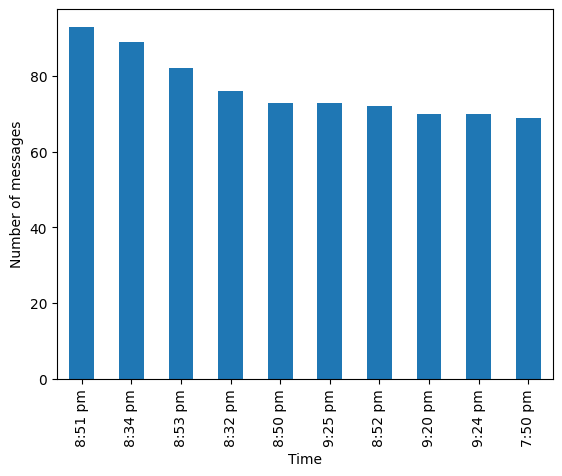

In [31]:
messages_df['Time'].value_counts().head(10).plot.bar() 
plt.xlabel('Time')
plt.ylabel('Number of messages')

There are 734434 words ina all messages.


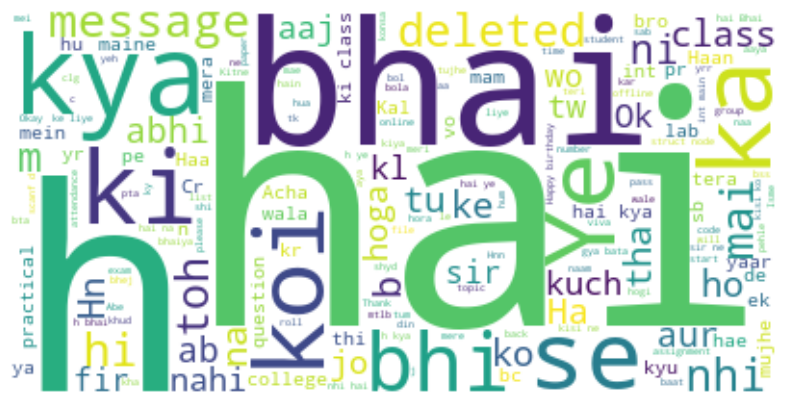

In [32]:
text = " ".join(review for review in messages_df.Message)
print("There are {} words ina all messages.".format(len(text)))
stopwords=set(STOPWORDS)

wordcloud=WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

Author name Arjun


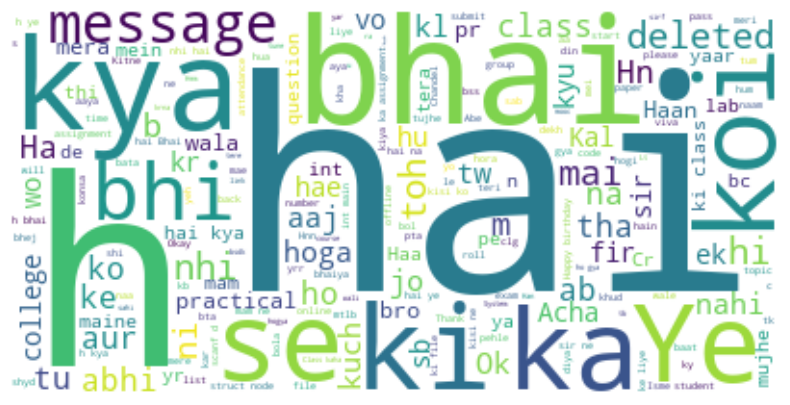

Author name Sarthak Badola


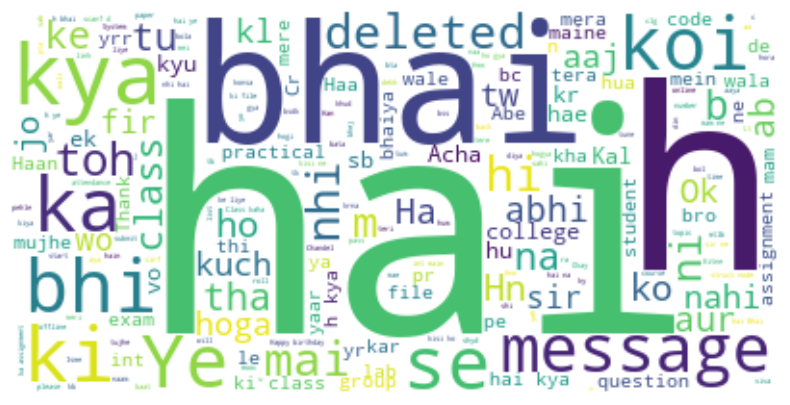

Author name Harsh


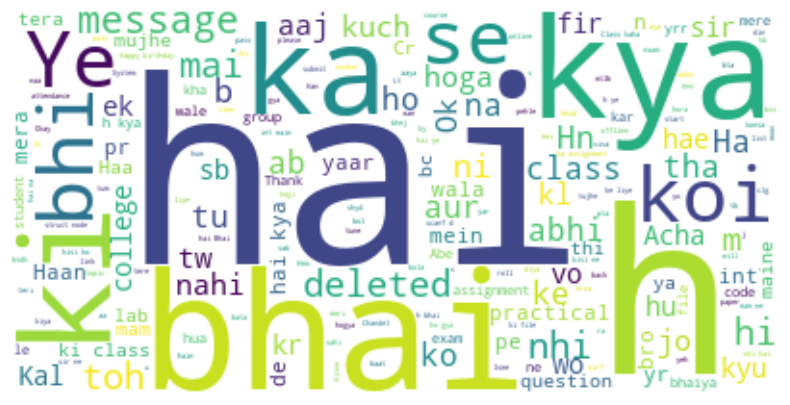

In [33]:
l=["Arjun","Sarthak Badola","Harsh"]
for i in range (len(l)):
    dumy_df=messages_df[messages_df['Author'] ==l[i]]
    text = " ".join(review for review in messages_df.Message)
    stopwords=set(STOPWORDS)
    wordcloud=WordCloud(stopwords=stopwords, background_color="white").generate(text)
    print("Author name",l[i])
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

Text(0, 0.5, 'Number of messages')

c:\Users\Ddmn\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\events.py:89: UserWarning:

Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.

c:\Users\Ddmn\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.



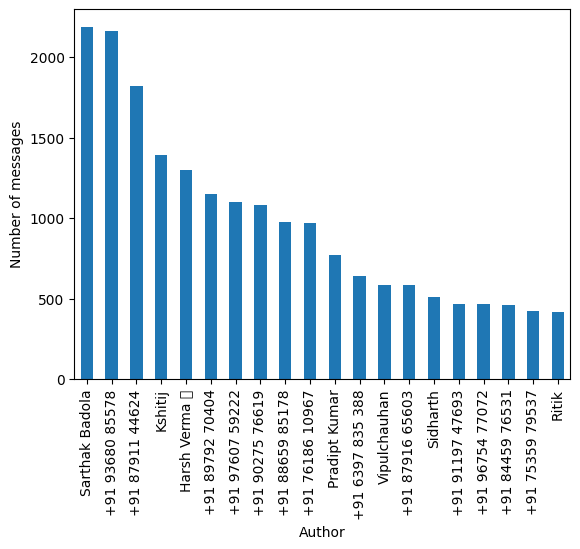

In [34]:
messages_df['Author'].value_counts().head(20).plot.bar()
plt.xlabel('Author')
plt.ylabel('Number of messages')

In [35]:
df['month_num']=df['Date'].dt.month

In [36]:
timeline=df.groupby(['year','month_num','month']).count()['Message'].reset_index()
time = []
for i in range(timeline.shape[0]):
    time.append(timeline['month'][i] + "-" + str(timeline['year'][i]))
timeline['time']=time
timeline    

,year,month_num,month,Message,time
0,2021,1,January,338,January-2021
1,2021,2,February,135,February-2021
2,2021,3,March,196,March-2021
3,2021,4,April,249,April-2021
4,2021,5,May,487,May-2021
5,2021,6,June,567,June-2021
6,2021,7,July,261,July-2021
7,2021,8,August,737,August-2021
8,2021,9,September,2679,September-2021
9,2021,10,October,2237,October-2021


<function matplotlib.pyplot.show(close=None, block=None)>

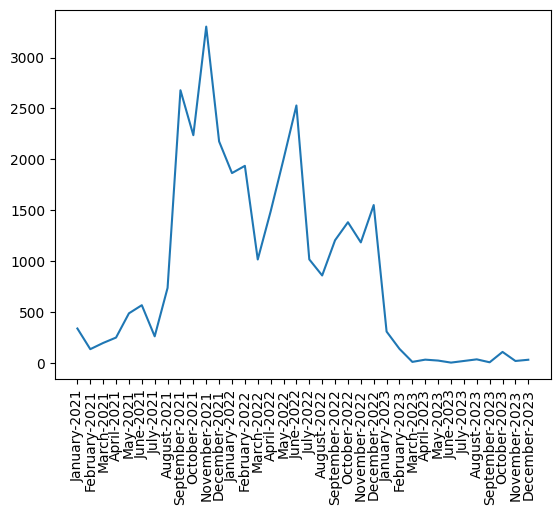

In [37]:
plt.plot(timeline['time'],timeline['Message'])
plt.xticks(rotation='vertical')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

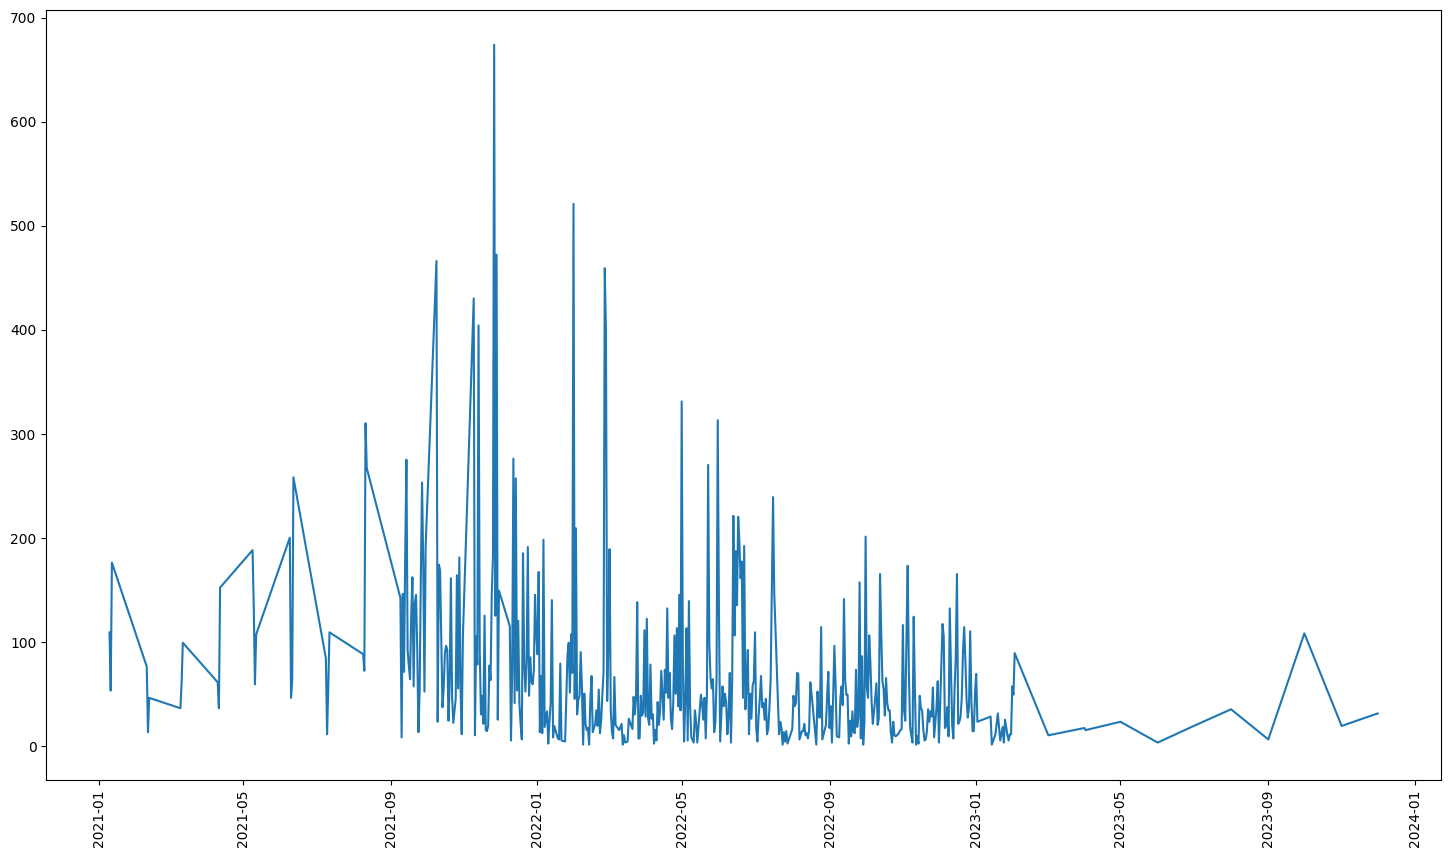

In [38]:
df['only_date']=df['Date'].dt.date
daily_timeline=df.groupby('only_date').count()['Message'].reset_index()
plt.figure(figsize=(18,10))
plt.plot(daily_timeline['only_date'],daily_timeline['Message'])
plt.xticks(rotation='vertical')
plt.show